<a href="https://colab.research.google.com/github/RayCyder/Intro/blob/main/ResNet_Implementation_on_CIFAR10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The Resnet Research paper can be accessed from here https://arxiv.org/pdf/1512.03385v1.pdf

#**Downloading the CIFAR10 datset and loading the data in Normalized form as torch.FloatTensor datatype and generating a validation set by dividing the training set in 80-20 ratio**
#**CIFAR10**
The CIFAR10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

More can be read from their page at https://www.cs.toronto.edu/~kriz/cifar.html

#**Image Augmentation**
In this cell, we perform some simple data augmentation by randomly flipping and cropping the given image data. We do this by defining a torchvision transform, and you can learn about all the transforms that are used to pre-process and augment data from the [PyTorch documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, random_split, DataLoader
transform = transforms.Compose([
    # transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
batch_size = 128
# --- Load full CIFAR-10 train set ---
trainset_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# --- (Optional) use only a subset for speed
subset_indices = torch.arrange(2048)
train_subset = Subset(trainset_full, subset_indices)

# --- Split subsert into train/validation ---
val_ratio = 0.1
n_total = len(train_subset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
train_set,val_set = random_split(train_subset,[n_train,n_val])
# --- DataLoaders ---
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set,batch_size = batch_size,shuffle=False)
# --- Test Set ---
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
# specify the image classes
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck']

# --- Class names ---
classes = trainset_full.classes
print(classes)
print(f"Train batches:{len(train_loader)}, Val batches:{len(val_loader)},Test batches:{len(test_loader)}"


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
16


#**Visualizing the Data**
Obtaining a batch of training data and plot the same with its lables using matplotlib library. You can also see how the transformations which you applied in the previous step show up in these visualizations.

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(3, 32, 32)


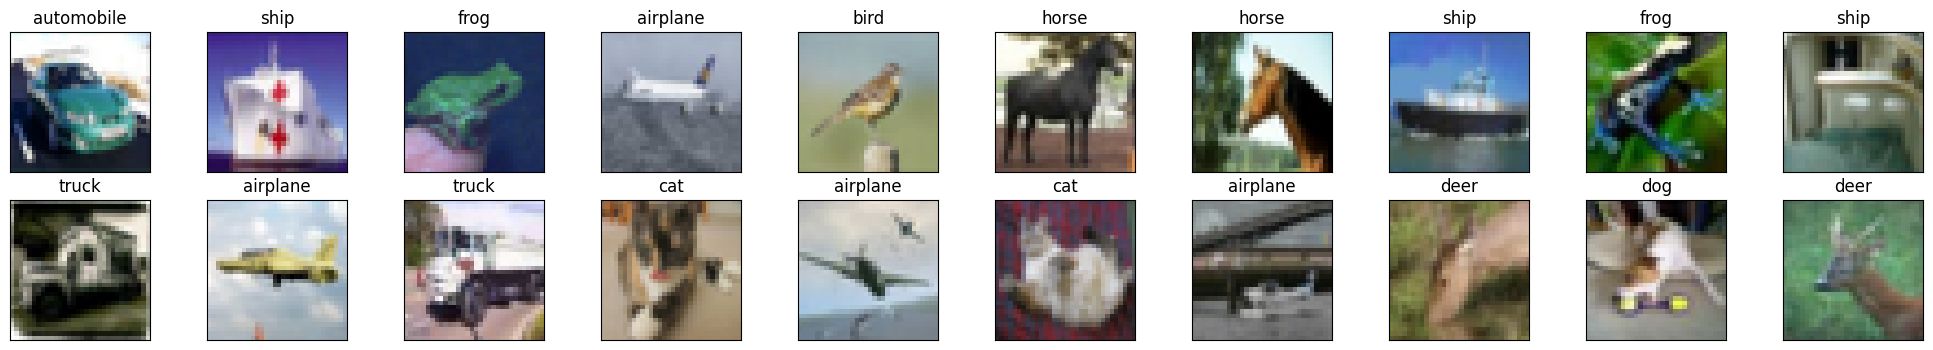

In [2]:
import matplotlib.pyplot as plt
import numpy as np
print(classes)
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
print(images[0].shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

#**Defining the Network Architecture**
In this section the entire Research Paper is implemented to define the Residual Network approach taken by the researchers

NOTE:

Output volume for a convolutional layer
To compute the output size of a given convolutional layer we can perform the following calculation (taken from Stanford's cs231n course):

We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# choose device
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Load a pre-defined ResNet18
ResNet18 = models.resnet18(weights=None)   # train from scratch
# or use pretrained weights:
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Adjust the final layer for your dataset (e.g. 10 classes for CIFAR-10)
num_ftrs = ResNet18.fc.in_features
ResNet18.fc = nn.Linear(num_ftrs, 10)
ResNet18 = ResNet18.to(device)


Using device: cuda


#**Specifying the Loss Function and Optimizer**
We use CrossEntropyLoss as Loss function and

[Stochastic Gradient Descent](https://leon.bottou.org/publications/pdf/compstat-2010.pdf) as Optimizer with momentum and weight decay specified by the research paper of ResNet

In [5]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
# specify optimizer
# optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()


In [13]:
'''
Muon-MVR For LLM Pretraining.
'''
import torch
import math


@torch.compile
def zeropower_via_newtonschulz5(G, steps=3, eps=1e-7):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    X /= (X.norm() + eps) # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    return X

class MuonMVR(torch.optim.Optimizer):
    r'''
    Standard MVR:\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t-1};\xi_{t})
    Approximate MVR:
        1.\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t-1};\xi_{t-1})
        2.\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t};\xi_{t-1}), It has low computational complexity
         and is more convenient in practice
    '''
    def __init__(self, params, lr=3e-3, momentum = 0.95 ,adamw_betas=(0.95, 0.99), eps=1e-8,
                 weight_decay=0.0, gamma=0.025, is_approx=False):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= momentum < 1.0:
            raise ValueError(f"Invalid momentum parameter: {momentum}")
        if not 0.0 <= adamw_betas[0] < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {adamw_betas[0]}")
        if not 0.0 <= adamw_betas[1] < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {adamw_betas[1]}")

        defaults = dict(lr=lr, momentum=momentum,adamw_betas=adamw_betas, eps=eps,
                       weight_decay=weight_decay, gamma=gamma)
        super().__init__(params, defaults)
        self.is_approx = is_approx

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        # adjusted_ratio = math.sqrt(A*B)
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    @torch.no_grad()
    def update_last_grad(self):
        if not self.is_approx:
            for group in self.param_groups:
                for p in group['params']:
                    state = self.state[p]
                    if "last_grad" not in state:
                        state["last_grad"] = torch.zeros_like(p)
                    state["last_grad"].zero_().add_(p.grad, alpha=1.0)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['adamw_betas']
            eps = group['eps']
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            gamma = group['gamma']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['last_grad'] = torch.zeros_like(p)
                    # state['previous_grad'] = torch.zeros_like(p)
                    if len(p.shape) != 2:  # Only for 2D tensors
                        state['exp_avg_sq'] = torch.zeros_like(p)

                state['step'] += 1
                last_grad = state['last_grad']
                if len(p.shape) == 2:
                    exp_avg = state['exp_avg']

                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (momentum / (1. - momentum))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    # Update moving averages
                    exp_avg.mul_(momentum).add_(c_t, alpha=1 - momentum)
                    update = zeropower_via_newtonschulz5(exp_avg.mul(1./(1.- momentum))) # whiten the update
                    adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(update, alpha=-adjusted_lr)
                else:
                    # For bias vectors - use simple update
                    step = state['step']
                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (beta1 / (1. - beta1))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    # avoid inductor lowering bug: compute norm explicitly and detach
                    # c_t_norm = torch.sqrt(torch.sum((c_t.detach() * c_t.detach()), dim=None))
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    exp_avg = state['exp_avg']
                    exp_avg_sq = state['exp_avg_sq']
                    exp_avg.lerp_(c_t, 1 - beta1)
                    exp_avg_sq.lerp_(c_t.square(), 1 - beta2)
                    g = exp_avg / (eps + exp_avg_sq.sqrt())
                    bias_correction1 = 1 - beta1**step
                    bias_correction2 = 1 - beta2**step
                    scale = bias_correction1 / bias_correction2**0.5
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(g, alpha=-lr / scale)

                if self.is_approx:
                    state['last_grad'].copy_(grad)

#**MuonMVR Training Loop**
Here we train the architecture on training data and check its validation loss by using the validation set and saving the model only if there is an improvement ie decrease in the validation loss.

## MVR2 Usage
3.  **Optimizer Modes**
    MuonMVR can be initialized in different modes to trade off between precision and computational cost.

    **Exact Variance Reduction (`is_approx=False`)**
    To achieve the most precise variance reduction, you must manually manage the model state. Before calculating the gradient for the previous batch, you need to load the model state from the previous iteration. This ensures that the gradient is computed with the correct model weights.
    ```python
    optimizer = MuonMVR(model.parameters(), lr=1e-3, is_approx=False)
    old_state_dict = {}
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Store the current model state
        cur_state_dict = {k: v.data.clone() for k, v in net.state_dict().items()}
    
        if old_state_dict:
            # Load the previous model state to compute the old gradient
            net.load_state_dict(old_state_dict)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.update_last_grad()
    
        # Restore the current model state to compute the new gradient
        net.load_state_dict(cur_state_dict)
        old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
        
        # Standard forward/backward pass and step
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    ```

In [15]:
learning_rate = 0.05
optimizer = MuonMVR(ResNet18.parameters(), lr=learning_rate,weight_decay=0.01,gamma=0.1,is_approx=False)
#optimizer = MuonMVR(model.parameters(), lr=1e-3, is_approx=False)


In [16]:
epochs = 100
# Cosine annealing: lr → eta_min by the end
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs,   # period (usually = total epochs)
    eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
)
losses = []
for epoch in range(epochs):
    ResNet18.train()
    running_loss = 0.0
    old_state_dict = {}
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        net = ResNet18
        # Store the current model state
        cur_state_dict = {k: v.data.clone() for k, v in net.state_dict().items()}

        if old_state_dict:
            # Load the previous model state to compute the old gradient
            net.load_state_dict(old_state_dict)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.update_last_grad()
        #restore state
        net.load_state_dict(cur_state_dict)
        old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}

        optimizer.zero_grad()
        outputs = ResNet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
     # step the scheduler once per epoch
    scheduler.step()
    losses.append(running_loss/max(1, len(train_loader)))
    current_lr = scheduler.get_last_lr()[0]  # single param group
    print(f"[{epoch+1}] loss: {losses[-1]:.3f} lr={current_lr:.6f}")

print("Training finished!")

/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


[1] loss: 3.340 lr=0.049989
[2] loss: 2.826 lr=0.049956
[3] loss: 2.257 lr=0.049900
[4] loss: 2.608 lr=0.049823
[5] loss: 4.126 lr=0.049723
[6] loss: 3.316 lr=0.049601
[7] loss: 2.837 lr=0.049458
[8] loss: 2.630 lr=0.049293
[9] loss: 2.493 lr=0.049107
[10] loss: 2.326 lr=0.048899
[11] loss: 2.405 lr=0.048670
[12] loss: 3.234 lr=0.048420
[13] loss: 2.842 lr=0.048149
[14] loss: 2.215 lr=0.047859
[15] loss: 2.173 lr=0.047548
[16] loss: 2.165 lr=0.047217
[17] loss: 1.940 lr=0.046867
[18] loss: 1.887 lr=0.046497
[19] loss: 1.924 lr=0.046109
[20] loss: 1.814 lr=0.045703
[21] loss: 1.767 lr=0.045278
[22] loss: 1.778 lr=0.044837
[23] loss: 1.684 lr=0.044377
[24] loss: 1.665 lr=0.043902
[25] loss: 1.571 lr=0.043410
[26] loss: 1.475 lr=0.042902
[27] loss: 1.505 lr=0.042380
[28] loss: 1.463 lr=0.041842
[29] loss: 1.489 lr=0.041290
[30] loss: 1.334 lr=0.040725
[31] loss: 1.408 lr=0.040147
[32] loss: 1.359 lr=0.039556
[33] loss: 1.407 lr=0.038953
[34] loss: 1.359 lr=0.038339
[35] loss: 1.292 lr=0.0

In [17]:
losses_mvr2 = [x for x in losses]

#**Clean Model**


In [18]:
ResNet18 = models.resnet18(weights=None)   # train from scratch
# or use pretrained weights:
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Adjust the final layer for your dataset (e.g. 10 classes for CIFAR-10)
num_ftrs = ResNet18.fc.in_features
ResNet18.fc = nn.Linear(num_ftrs, 10)
ResNet18 = ResNet18.to(device)

#**SGD Training Loop**

In [19]:
learning_rate = 0.1
optimizer = optim.SGD(ResNet18.parameters(), lr=learning_rate, weight_decay=0.01)

In [20]:

epochs = 100
# Cosine annealing: lr → eta_min by the end
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs,   # period (usually = total epochs)
    eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
)
losses = []
for epoch in range(epochs):
    ResNet18.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = ResNet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
     # step the scheduler once per epoch
    scheduler.step()
    losses.append(running_loss/max(1, len(train_loader)))
    current_lr = scheduler.get_last_lr()[0]  # single param group
    print(f"[{epoch+1}] loss: {losses[-1]:.3f} lr={current_lr:.6f}")

print("Training finished!")

[1] loss: 3.586 lr=0.099978
[2] loss: 2.223 lr=0.099911
[3] loss: 1.701 lr=0.099800
[4] loss: 1.442 lr=0.099645
[5] loss: 1.253 lr=0.099446
[6] loss: 0.946 lr=0.099203
[7] loss: 0.826 lr=0.098916
[8] loss: 0.580 lr=0.098586
[9] loss: 0.390 lr=0.098213
[10] loss: 0.195 lr=0.097798
[11] loss: 0.139 lr=0.097340
[12] loss: 0.055 lr=0.096840
[13] loss: 0.014 lr=0.096299
[14] loss: 0.007 lr=0.095717
[15] loss: 0.004 lr=0.095095
[16] loss: 0.004 lr=0.094434
[17] loss: 0.003 lr=0.093733
[18] loss: 0.003 lr=0.092995
[19] loss: 0.003 lr=0.092219
[20] loss: 0.003 lr=0.091406
[21] loss: 0.003 lr=0.090557
[22] loss: 0.003 lr=0.089673
[23] loss: 0.003 lr=0.088755
[24] loss: 0.003 lr=0.087804
[25] loss: 0.003 lr=0.086820
[26] loss: 0.004 lr=0.085805
[27] loss: 0.004 lr=0.084759
[28] loss: 0.003 lr=0.083684
[29] loss: 0.004 lr=0.082581
[30] loss: 0.004 lr=0.081450
[31] loss: 0.004 lr=0.080294
[32] loss: 0.004 lr=0.079112
[33] loss: 0.004 lr=0.077907
[34] loss: 0.004 lr=0.076679
[35] loss: 0.004 lr=0.0

In [21]:
losses_sgd = [x for x in losses]

#**show losses for two optimizer**

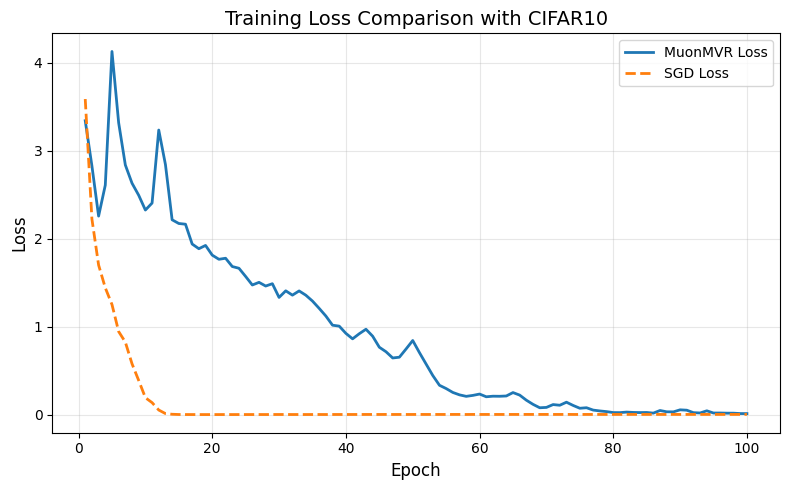

In [22]:
epochs_list = range(1,epochs+1)
plt.figure(figsize=(8, 5))  # larger, readable figure

# plot both losses
plt.plot(epochs_list, losses_mvr2, label="MuonMVR Loss", linewidth=2)
plt.plot(epochs_list, losses_sgd, label="SGD Loss", linewidth=2, linestyle="--")

# formatting
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Comparison with CIFAR10", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#**Testing Loop**
The real test of the model architecture how well does the model recognizes the image and what is the accuracy on the test data

In [ ]:
# ResNet18.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = ResNet18(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy: {100 * correct / total:.2f}%")